## Homoscedastic uncertainty

### Example of learning the aleatoric homoscedastic uncertainty by learning a simple linear regression

In [1]:
#!pip install keras==2.0.8
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, concatenate, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.initializers import RandomNormal
from keras.layers import multiply, add, Reshape, RepeatVector
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


First we create some samples from 0 to 40 and add some noise. In this case we have two variables with the same noise distribution, x and z, that we'll use to show that gimas can be calculated using two variables as inputs.

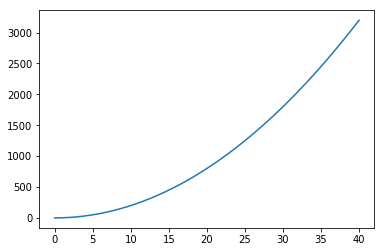

In [69]:
NUMBER_OF_SAMPLES = 10000
x = np.linspace(0, 40, NUMBER_OF_SAMPLES)#, dtype="int32")  # 100000 values between 0 and 100
deltax = np.random.normal(0, 1, x.size)
x_prima = x + deltax
z = np.linspace(0, 40, NUMBER_OF_SAMPLES)
deltaz = np.random.normal(0, 1, z.size)
z_prima = z + deltaz

y = 2 * x * z
plt.plot(x, y)
plt.show()

First we try a model without calculating the sigma and plot some results.

Epoch 1/150
10000/10000 [==============================] - 0s - loss: 1418799.3957    
Epoch 2/150
10000/10000 [==============================] - 0s - loss: 1367852.2798    
Epoch 3/150
10000/10000 [==============================] - 0s - loss: 1325892.1043    
Epoch 4/150
10000/10000 [==============================] - 0s - loss: 1286054.6106    
Epoch 5/150
10000/10000 [==============================] - 0s - loss: 1247628.4167    
Epoch 6/150
10000/10000 [==============================] - 0s - loss: 1210344.5318    
Epoch 7/150
10000/10000 [==============================] - 0s - loss: 1174065.2910    
Epoch 8/150
10000/10000 [==============================] - 0s - loss: 1138706.9796    
Epoch 9/150
10000/10000 [==============================] - 0s - loss: 1104213.2286   
Epoch 10/150
10000/10000 [==============================] - 0s - loss: 1070541.3770   
Epoch 11/150
10000/10000 [==============================] - 0s - loss: 1037658.6077    
Epoch 12/150
10000/10000 [=================

10000/10000 [==============================] - 0s - loss: 6792.7228     
Epoch 96/150
10000/10000 [==============================] - 0s - loss: 6359.5403     
Epoch 97/150
10000/10000 [==============================] - 0s - loss: 5988.5577     
Epoch 98/150
10000/10000 [==============================] - 0s - loss: 5673.1516     
Epoch 99/150
10000/10000 [==============================] - 0s - loss: 5406.9734     
Epoch 100/150
10000/10000 [==============================] - 0s - loss: 5184.1527     
Epoch 101/150
10000/10000 [==============================] - 0s - loss: 4999.1978     
Epoch 102/150
10000/10000 [==============================] - 0s - loss: 4846.9919     
Epoch 103/150
10000/10000 [==============================] - 0s - loss: 4722.9305     
Epoch 104/150
10000/10000 [==============================] - 0s - loss: 4622.7794     
Epoch 105/150
10000/10000 [==============================] - 0s - loss: 4542.7842     
Epoch 106/150
10000/10000 [==============================] - 

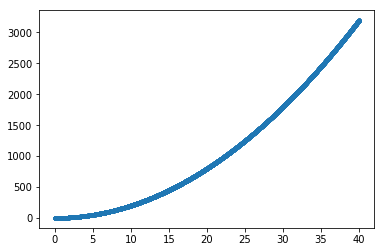

In [78]:
raw_input1 = Input(shape=(1,))
raw_input2 = Input(shape=(1,))
product = multiply([raw_input1,raw_input2])
raw_preds = Dense(1, activation='linear', name="preds", use_bias=False)(product)
adam = Adam(lr=0.0005)
rawmodel = Model(inputs=[raw_input1,raw_input2],outputs=raw_preds)
rawmodel.compile(optimizer=adam, loss='mean_squared_error')
rawmodel.fit([x_prima, z_prima], y, batch_size=128, epochs=150, shuffle=False)
raw_result = rawmodel.predict([x, z])
plt.plot(x, raw_result[:,0],'.')
plt.show()

These are the functions used to include the calculation of the sigmas in the loss.
Note that we use the trick of concatenating the sigma to the ouput, so the prediction is at index 0 and the sigma is at index 1 of the resulting output.

In [82]:
def aleatoric_loss(y_true, y_pred):
    sigma = y_pred[:, 1]
    epsilon = 1e-6
    y_pred_prima = y_pred[:, 0]
    output_value = ((K.square(y_pred_prima - y_true[:, 0])) / (K.square(sigma)+ epsilon)) + K.log(K.square(sigma) + epsilon)
    return K.mean(output_value, axis=-1)

def aleatoric_rms(y_true, y_pred):
    y_pred_prima = y_pred[:, 0]
    y_true_prima = y_true[:, 0]
    output_value = K.square(y_pred_prima - y_true_prima)
    return K.mean(output_value, axis=-1)

Then we try a model where the sigmas are computed. In this case we have one sigma that don't belong to any of the inputs. Sigma is trained in the loss together with the mean squared error of the labels and the predictions.

In [83]:
input1 = Input(shape=(1,))
input2 = Input(shape=(1,))
input_sigma = Input(shape=(1,))
product = multiply([input1,input2])
preds = Dense(1, activation='linear', name="preds", use_bias=False, weights=rawmodel.layers[3].get_weights())(product)
sigma = Dense(1, activation='linear', name="sigma", kernel_initializer=RandomNormal(mean=1.0, stddev=0.05, seed=None), use_bias=True)(input_sigma)

aleatoric_output = concatenate([preds, sigma])
adam = Adam(lr=0.001)
model = Model(inputs=[input1,input2,input_sigma],outputs=aleatoric_output)
model.compile(optimizer=adam, loss=aleatoric_loss, metrics=[aleatoric_rms])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_60 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
input_61 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
multiply_24 (Multiply)           (None, 1)             0           input_60[0][0]                   
                                                                   input_61[0][0]                   
____________________________________________________________________________________________________
input_62 (InputLayer)            (None, 1)             0                                   

In [84]:
BATCH_SIZE = 64
model.fit([x_prima,z_prima,np.ones(NUMBER_OF_SAMPLES)], np.expand_dims(y, axis=1).repeat(2, axis=1), batch_size=BATCH_SIZE, epochs=1000, shuffle=False)

Epoch 1/1000
10000/10000 [==============================] - 0s - loss: 2495.2640 - aleatoric_rms: 4283.1682     
Epoch 2/1000
10000/10000 [==============================] - 0s - loss: 1763.8539 - aleatoric_rms: 4291.1487     
Epoch 3/1000
10000/10000 [==============================] - 0s - loss: 1437.3614 - aleatoric_rms: 4294.7037     
Epoch 4/1000
10000/10000 [==============================] - 0s - loss: 1223.9726 - aleatoric_rms: 4296.1256     
Epoch 5/1000
10000/10000 [==============================] - 0s - loss: 1070.2790 - aleatoric_rms: 4296.7230    
Epoch 6/1000
10000/10000 [==============================] - 0s - loss: 953.0029 - aleatoric_rms: 4297.0057     
Epoch 7/1000
10000/10000 [==============================] - 0s - loss: 859.8857 - aleatoric_rms: 4297.1511     
Epoch 8/1000
10000/10000 [==============================] - 0s - loss: 783.7469 - aleatoric_rms: 4297.2244     
Epoch 9/1000
10000/10000 [==============================] - 0s - loss: 720.0603 - aleatoric_rms: 429

10000/10000 [==============================] - 0s - loss: 58.6454 - aleatoric_rms: 4296.4424     
Epoch 74/1000
10000/10000 [==============================] - 0s - loss: 57.1023 - aleatoric_rms: 4296.4280     
Epoch 75/1000
10000/10000 [==============================] - 0s - loss: 55.6146 - aleatoric_rms: 4296.4094     
Epoch 76/1000
10000/10000 [==============================] - 0s - loss: 54.1802 - aleatoric_rms: 4296.3912     
Epoch 77/1000
10000/10000 [==============================] - 0s - loss: 52.7970 - aleatoric_rms: 4296.3726     
Epoch 78/1000
10000/10000 [==============================] - 0s - loss: 51.4630 - aleatoric_rms: 4296.3541     
Epoch 79/1000
10000/10000 [==============================] - 0s - loss: 50.1762 - aleatoric_rms: 4296.3388     
Epoch 80/1000
10000/10000 [==============================] - 0s - loss: 48.9348 - aleatoric_rms: 4296.3204     
Epoch 81/1000
10000/10000 [==============================] - 0s - loss: 47.7371 - aleatoric_rms: 4296.3026     
Epoch 

10000/10000 [==============================] - 0s - loss: 16.4493 - aleatoric_rms: 4295.2686     
Epoch 146/1000
10000/10000 [==============================] - 0s - loss: 16.2888 - aleatoric_rms: 4295.2553     
Epoch 147/1000
10000/10000 [==============================] - 0s - loss: 16.1325 - aleatoric_rms: 4295.2431     
Epoch 148/1000
10000/10000 [==============================] - 0s - loss: 15.9802 - aleatoric_rms: 4295.2274     
Epoch 149/1000
10000/10000 [==============================] - 0s - loss: 15.8319 - aleatoric_rms: 4295.2152     
Epoch 150/1000
10000/10000 [==============================] - 0s - loss: 15.6873 - aleatoric_rms: 4295.2053     
Epoch 151/1000
10000/10000 [==============================] - 0s - loss: 15.5464 - aleatoric_rms: 4295.1922     
Epoch 152/1000
10000/10000 [==============================] - 0s - loss: 15.4091 - aleatoric_rms: 4295.1796     
Epoch 153/1000
10000/10000 [==============================] - 0s - loss: 15.2753 - aleatoric_rms: 4295.1658    

10000/10000 [==============================] - 0s - loss: 10.9305 - aleatoric_rms: 4294.5790     
Epoch 218/1000
10000/10000 [==============================] - 0s - loss: 10.8999 - aleatoric_rms: 4294.5718     
Epoch 219/1000
10000/10000 [==============================] - 0s - loss: 10.8700 - aleatoric_rms: 4294.5647     
Epoch 220/1000
10000/10000 [==============================] - 0s - loss: 10.8407 - aleatoric_rms: 4294.5579     
Epoch 221/1000
10000/10000 [==============================] - 0s - loss: 10.8119 - aleatoric_rms: 4294.5505     
Epoch 222/1000
10000/10000 [==============================] - 0s - loss: 10.7838 - aleatoric_rms: 4294.5457     
Epoch 223/1000
10000/10000 [==============================] - 0s - loss: 10.7562 - aleatoric_rms: 4294.5389     
Epoch 224/1000
10000/10000 [==============================] - 0s - loss: 10.7292 - aleatoric_rms: 4294.5320     
Epoch 225/1000
10000/10000 [==============================] - 0s - loss: 10.7027 - aleatoric_rms: 4294.5260    

10000/10000 [==============================] - 0s - loss: 9.7424 - aleatoric_rms: 4294.1825     
Epoch 291/1000
10000/10000 [==============================] - 0s - loss: 9.7351 - aleatoric_rms: 4294.1785     
Epoch 292/1000
10000/10000 [==============================] - 0s - loss: 9.7279 - aleatoric_rms: 4294.1742     
Epoch 293/1000
10000/10000 [==============================] - 0s - loss: 9.7209 - aleatoric_rms: 4294.1688     
Epoch 294/1000
10000/10000 [==============================] - 0s - loss: 9.7140 - aleatoric_rms: 4294.1646     
Epoch 295/1000
10000/10000 [==============================] - 0s - loss: 9.7072 - aleatoric_rms: 4294.1608     
Epoch 296/1000
10000/10000 [==============================] - 0s - loss: 9.7005 - aleatoric_rms: 4294.1577     
Epoch 297/1000
10000/10000 [==============================] - 0s - loss: 9.6940 - aleatoric_rms: 4294.1537     
Epoch 298/1000
10000/10000 [==============================] - 0s - loss: 9.6876 - aleatoric_rms: 4294.1504     
Epoch 2

10000/10000 [==============================] - 0s - loss: 9.4525 - aleatoric_rms: 4293.9197     
Epoch 364/1000
10000/10000 [==============================] - 0s - loss: 9.4507 - aleatoric_rms: 4293.9154     
Epoch 365/1000
10000/10000 [==============================] - 0s - loss: 9.4490 - aleatoric_rms: 4293.9134     
Epoch 366/1000
10000/10000 [==============================] - 0s - loss: 9.4473 - aleatoric_rms: 4293.9111     
Epoch 367/1000
10000/10000 [==============================] - 0s - loss: 9.4456 - aleatoric_rms: 4293.9070     
Epoch 368/1000
10000/10000 [==============================] - 0s - loss: 9.4440 - aleatoric_rms: 4293.9044     
Epoch 369/1000
10000/10000 [==============================] - 0s - loss: 9.4424 - aleatoric_rms: 4293.9026     
Epoch 370/1000
10000/10000 [==============================] - 0s - loss: 9.4408 - aleatoric_rms: 4293.8986     
Epoch 371/1000
10000/10000 [==============================] - 0s - loss: 9.4392 - aleatoric_rms: 4293.8956     
Epoch 3

10000/10000 [==============================] - 0s - loss: 9.3839 - aleatoric_rms: 4293.7460     
Epoch 437/1000
10000/10000 [==============================] - 0s - loss: 9.3835 - aleatoric_rms: 4293.7442     
Epoch 438/1000
10000/10000 [==============================] - 0s - loss: 9.3831 - aleatoric_rms: 4293.7436     
Epoch 439/1000
10000/10000 [==============================] - 0s - loss: 9.3827 - aleatoric_rms: 4293.7412     
Epoch 440/1000
10000/10000 [==============================] - 0s - loss: 9.3823 - aleatoric_rms: 4293.7390     
Epoch 441/1000
10000/10000 [==============================] - 0s - loss: 9.3819 - aleatoric_rms: 4293.7364     
Epoch 442/1000
10000/10000 [==============================] - 0s - loss: 9.3816 - aleatoric_rms: 4293.7349     
Epoch 443/1000
10000/10000 [==============================] - 0s - loss: 9.3812 - aleatoric_rms: 4293.7328     
Epoch 444/1000
10000/10000 [==============================] - 0s - loss: 9.3809 - aleatoric_rms: 4293.7320     
Epoch 4

10000/10000 [==============================] - 0s - loss: 9.3688 - aleatoric_rms: 4293.6505     
Epoch 510/1000
10000/10000 [==============================] - 0s - loss: 9.3687 - aleatoric_rms: 4293.6493     
Epoch 511/1000
10000/10000 [==============================] - 0s - loss: 9.3686 - aleatoric_rms: 4293.6491     
Epoch 512/1000
10000/10000 [==============================] - 0s - loss: 9.3686 - aleatoric_rms: 4293.6485     
Epoch 513/1000
10000/10000 [==============================] - 0s - loss: 9.3685 - aleatoric_rms: 4293.6487     
Epoch 514/1000
10000/10000 [==============================] - 0s - loss: 9.3684 - aleatoric_rms: 4293.6473     
Epoch 515/1000
10000/10000 [==============================] - 0s - loss: 9.3683 - aleatoric_rms: 4293.6466     
Epoch 516/1000
10000/10000 [==============================] - 0s - loss: 9.3683 - aleatoric_rms: 4293.6448     
Epoch 517/1000
10000/10000 [==============================] - 0s - loss: 9.3682 - aleatoric_rms: 4293.6437     
Epoch 5

10000/10000 [==============================] - 0s - loss: 9.3658 - aleatoric_rms: 4293.6035     
Epoch 582/1000
10000/10000 [==============================] - 0s - loss: 9.3658 - aleatoric_rms: 4293.6033     
Epoch 583/1000
10000/10000 [==============================] - 0s - loss: 9.3658 - aleatoric_rms: 4293.6028     
Epoch 584/1000
10000/10000 [==============================] - 0s - loss: 9.3657 - aleatoric_rms: 4293.6018     
Epoch 585/1000
10000/10000 [==============================] - 0s - loss: 9.3657 - aleatoric_rms: 4293.6005     
Epoch 586/1000
10000/10000 [==============================] - 0s - loss: 9.3657 - aleatoric_rms: 4293.5997     
Epoch 587/1000
10000/10000 [==============================] - 0s - loss: 9.3657 - aleatoric_rms: 4293.5999     
Epoch 588/1000
10000/10000 [==============================] - 0s - loss: 9.3657 - aleatoric_rms: 4293.5993     
Epoch 589/1000
10000/10000 [==============================] - 0s - loss: 9.3657 - aleatoric_rms: 4293.5987     
Epoch 5

10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5783     
Epoch 655/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5773     
Epoch 656/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5774     
Epoch 657/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5769     
Epoch 658/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5769     
Epoch 659/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5770     
Epoch 660/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5763     
Epoch 661/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5767     
Epoch 662/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5764     
Epoch 6

10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5667     
Epoch 728/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5667     
Epoch 729/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5667     
Epoch 730/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5668     
Epoch 731/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5668     
Epoch 732/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5663     
Epoch 733/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5664     
Epoch 734/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5660     
Epoch 735/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5660     
Epoch 7

10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5618     
Epoch 801/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5618     
Epoch 802/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5618     
Epoch 803/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5620     
Epoch 804/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5618     
Epoch 805/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5620     
Epoch 806/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5618     
Epoch 807/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5621     
Epoch 808/1000
10000/10000 [==============================] - 0s - loss: 9.3652 - aleatoric_rms: 4293.5620     
Epoch 8

10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5594     
Epoch 874/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5594     
Epoch 875/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5594     
Epoch 876/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5594     
Epoch 877/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5594     
Epoch 878/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5594     
Epoch 879/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5594     
Epoch 880/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5594     
Epoch 881/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5594     
Epoch 8

10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5575     
Epoch 946/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5575     
Epoch 947/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5577     
Epoch 948/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5575     
Epoch 949/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5577     
Epoch 950/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5577     
Epoch 951/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5577     
Epoch 952/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5577     
Epoch 953/1000
10000/10000 [==============================] - 0s - loss: 9.3653 - aleatoric_rms: 4293.5577     
Epoch 9

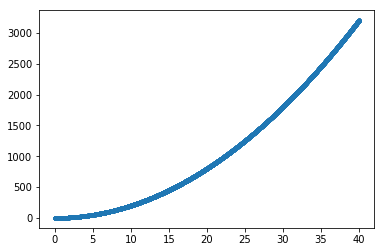

In [85]:
result = model.predict([x,z,np.ones(NUMBER_OF_SAMPLES)])
plt.plot(x, result[:,0],'.')
plt.show()

Here we are the homoscedastic uncertainty:

In [86]:
model_sigmas_x = Model(inputs=[input_sigma], outputs=sigma)
sigmas_x = model_sigmas_x.predict(np.ones(1))
sigmas_x[0][0]

65.887764

In [87]:
rawmodel.layers[3].get_weights()

[array([[ 1.99830151]], dtype=float32)]

In [88]:
model.layers[4].get_weights()

[array([[ 2.00392318]], dtype=float32)]

In [89]:
rawmodel.predict([np.array([2]),np.ones(1)])

array([[ 3.99660301]], dtype=float32)

In [90]:
model.predict([np.array([2]),np.ones(1),np.ones(1)])

array([[  4.00784636,  65.88776398]], dtype=float32)